In [ ]:
#Step 16 trains and tests on both hospitals with CPT as the only feature using random forest. 

In [1]:
#Import the necessary modules. 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_curve, auc, confusion_matrix, accuracy_score
)
from sklearn.utils import resample
from skopt import BayesSearchCV
from scipy.interpolate import interp1d



In [2]:
#Load the data
matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')

#Shuffle the data
matrix = matrix.sample(random_state=2023, frac=1, ignore_index=True)

#Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop=True)

#Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop=True)

#Ensure both DataFrames have the same length
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"

#Add 'annot' back to X_data
X_data['annot'] = y_data_pre['annot']

#Specify the ICD columns
cpt_columns = ['CT', 'MRI']

#Select only the relevant columns for X_data
X_data = X_data[['BDSPPatientID'] + cpt_columns + ['annot']]
print(X_data)

#Prepare y_data
y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)

#Update y_data_pre
y_data_pre = y_data
print(y_data_pre)

#Extract 'annot' as y
y = y_data_pre['annot']
print(y)

#Drop 'annot' from X_data
X_data = X_data.drop(['annot'], axis=1)

#Create X by selecting only the ICD columns
X = X_data.drop(['BDSPPatientID'], axis=1)
print(X)


      BDSPPatientID  CT  MRI  annot
0         118166468   1    1      0
1         151027760   0    0      0
2         151147664   0    0      0
3         118696581   1    1      0
4         114871134   0    0      0
...             ...  ..  ...    ...
1495      115864242   1    1      0
1496      150772328   1    0      0
1497      119972331   1    1      0
1498      151202679   1    0      1
1499      151038873   0    0      0

[1500 rows x 4 columns]
      BDSPPatientID  annot
0         118166468      0
1         151027760      0
2         151147664      0
3         118696581      0
4         114871134      0
...             ...    ...
1495      115864242      0
1496      150772328      0
1497      119972331      0
1498      151202679      1
1499      151038873      0

[1500 rows x 2 columns]
      BDSPPatientID  annot
0         118166468      0
1         151027760      0
2         151147664      0
3         118696581      0
4         114871134      0
...             ...    ...
1495 

In [3]:
#Conduct the nested 10 fold cross validation using random forest.
#Initialize variables for storing results
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}

#Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

#Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

for cvi, (train_index, test_index) in enumerate(gkf.split(X, y, groups=y_data_pre['BDSPPatientID'])):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]
        
    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())


    model = RandomForestClassifier(
        n_estimators=100,
        random_state=2023,
        n_jobs=-1
    )
    
    search_spaces = {
        'n_estimators': (50, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
    }
    
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50,
        scoring='roc_auc',
        n_jobs=47,
        cv=10,
        random_state=2023
    )
    
    model_cv.fit(Xtr, ytr)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:, 1]
    yte_pred = model.predict_proba(Xte)[:, 1]

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)

    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    model_filename = f'CPT_only_RF_model_train_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)


    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    feature_importances = model.feature_importances_
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('RF_CPT_only_fold_patient_ids_.csv', index=False)

/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Feature importances for this fold:
  Feature  Importance
0      CT     0.64829
1     MRI     0.35171
[0.7586936090225564]
[0.5830477893763535]
Feature importances for this fold:
  Feature  Importance
0      CT    0.671285
1     MRI    0.328715
[0.7586936090225564, 0.7035818713450293]
[0.5830477893763535, 0.471951566951567]
Feature importances for this fold:
  Feature  Importance
0      CT    0.633574
1     MRI    0.366426
[0.7586936090225564, 0.7035818713450293, 0.7041823308270676]
[0.5830477893763535, 0.471951566951567, 0.51460707591567]
Feature importances for this fold:
  Feature  Importance
0      CT    0.641829
1     MRI    0.358171
[0.7586936090225564, 0.7035818713450293, 0.7041823308270676, 0.7253086419753086]
[0.5830477893763535, 0.471951566951567, 0.51460707591567, 0.5459822602857669]
Feature importances for this fold:
  Feature  Importance
0      CT    0.658131
1     MRI    0.341869
[0.7586936090225564, 0.7035818713450293, 0.7041823308270676, 0.7253086419753086, 0.74204545454

In [4]:
#Print the AUROC and AUPRC
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))


0.7209391270077437
0.5056997856659483


/tmp/ipykernel_32319/4068433578.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_importance_df.loc[i, 'Feature'] = feature


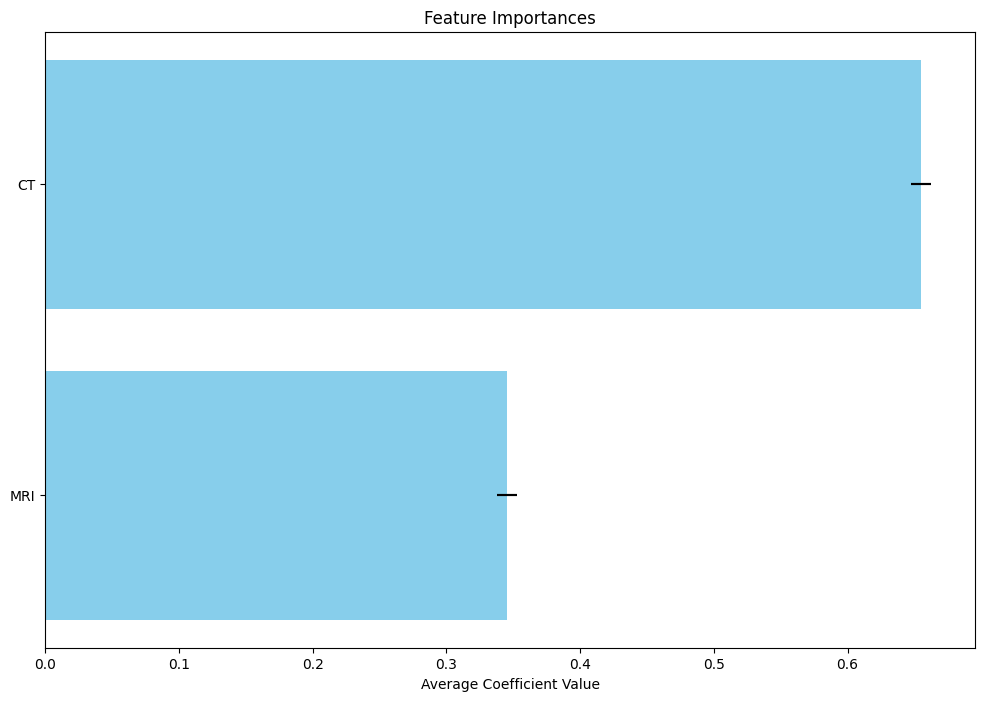

<Figure size 640x480 with 0 Axes>

In [5]:
#Create the feature importances figure. 
#Aggregate feature importances by averaging over folds
feature_importance_df = pd.DataFrame(data={'Feature':[], 'Importance':[], 'Importance_se':[]})

for i, (feature, importances) in enumerate(feature_importances_dict.items()):
    feature_importance_df.loc[i, 'Feature'] = feature
    feature_importance_df.loc[i, 'Importance'] = np.mean(importances)
    feature_importance_df.loc[i, 'Importance_se'] = np.std(importances)/np.sqrt(len(importances))

feature_importance_df = feature_importance_df.sort_values('Importance', axis=0, ignore_index=True, ascending=False)

feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/CPT_feat_importances_both_hospitals_.csv', index=False)#

#Select top 10 and bottom 10 features
top_features = feature_importance_df.Feature.iloc[:10]
top_importances = feature_importance_df.Importance.iloc[:10]
top_importances_se = feature_importance_df.Importance_se.iloc[:10]
bottom_features = feature_importance_df.Feature.iloc[-10:]
bottom_importances = feature_importance_df.Importance.iloc[-10:]
bottom_importances_se = feature_importance_df.Importance_se.iloc[-10:]

#Combine top and bottom features for plotting
plot_features = pd.concat([top_features, bottom_features])
plot_importances = pd.concat([top_importances, bottom_importances])
plot_importances_se = pd.concat([top_importances_se, bottom_importances_se])

#Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue', xerr=2*plot_importances_se) 
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/CPT_feat_importances_both_hospitals_.png')#

In [7]:
#Print the confusion matrixes.
cf_cv

[array([[78, 34],
        [12, 26]]),
 array([[48, 66],
        [ 2, 34]]),
 array([[72, 40],
        [14, 24]]),
 array([[71, 37],
        [16, 26]]),
 array([[69, 41],
        [12, 28]]),
 array([[81, 38],
        [ 9, 22]]),
 array([[71, 38],
        [18, 23]]),
 array([[76, 34],
        [16, 24]]),
 array([[59, 57],
        [11, 23]]),
 array([[80, 41],
        [14, 15]])]

In [8]:
# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)

Overall Confusion Matrix:
 [[705 426]
 [124 245]]


In [9]:
#Calculate the metrics for each fold. 
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

#Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.6933
Precision: 0.4333
Recall: 0.6842
F1 Score: 0.5306

Metrics for Fold 2:
Accuracy: 0.5467
Precision: 0.3400
Recall: 0.9444
F1 Score: 0.5000

Metrics for Fold 3:
Accuracy: 0.6400
Precision: 0.3750
Recall: 0.6316
F1 Score: 0.4706

Metrics for Fold 4:
Accuracy: 0.6467
Precision: 0.4127
Recall: 0.6190
F1 Score: 0.4952

Metrics for Fold 5:
Accuracy: 0.6467
Precision: 0.4058
Recall: 0.7000
F1 Score: 0.5138

Metrics for Fold 6:
Accuracy: 0.6867
Precision: 0.3667
Recall: 0.7097
F1 Score: 0.4835

Metrics for Fold 7:
Accuracy: 0.6267
Precision: 0.3770
Recall: 0.5610
F1 Score: 0.4510

Metrics for Fold 8:
Accuracy: 0.6667
Precision: 0.4138
Recall: 0.6000
F1 Score: 0.4898

Metrics for Fold 9:
Accuracy: 0.5467
Precision: 0.2875
Recall: 0.6765
F1 Score: 0.4035

Metrics for Fold 10:
Accuracy: 0.6333
Precision: 0.2679
Recall: 0.5172
F1 Score: 0.3529

Overall Metrics:
Accuracy: 0.6333
Precision: 0.3651
Recall: 0.6640
F1 Score: 0.4712


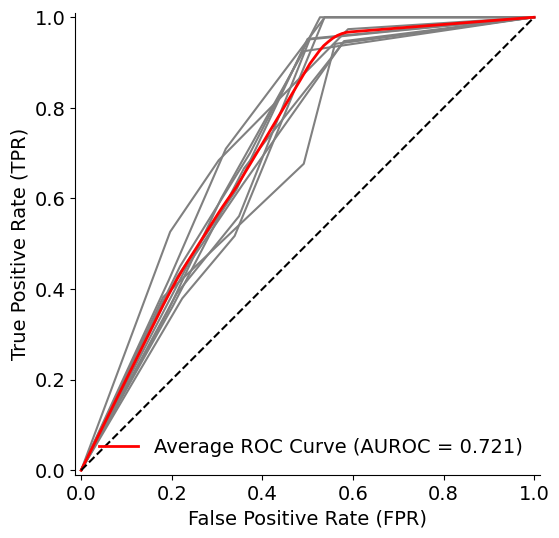

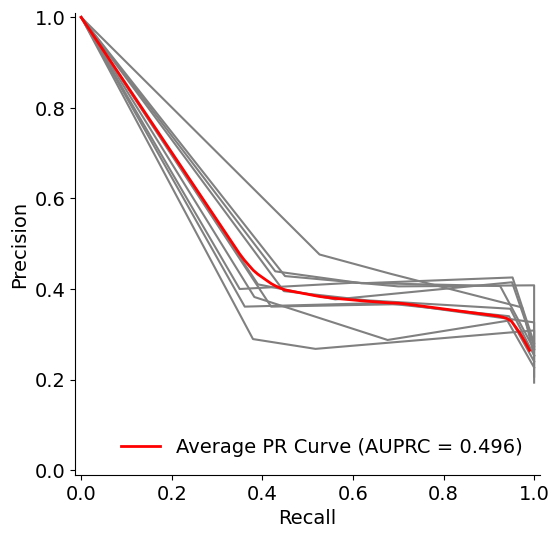

0.7209391270077437
0.46909427857611863


In [22]:
#Create the AUROC and AUPRC plot for all 10 folds.
#Function to format the plot
def format_plot():
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

#Plot all ROC curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='gray')  # Set line color to black

#Add a solid red line for the average ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Extended range for x-axis
mean_tpr = np.mean([interp1d(fpr, tpr, bounds_error=False, fill_value=0)(mean_fpr) for fpr, tpr, _ in roc_curves], axis=0)

#Calculate AUROC for the average ROC curve
average_auc = auc(mean_fpr, mean_tpr)

#Plot the average ROC curve with its AUROC value in the legend
plt.plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Average ROC Curve (AUROC = {average_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  
format_plot()
plt.axis('equal')
plt.xlim(-0.01, 1.01)  
plt.ylim(-0.01, 1.01)  
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.savefig('CPT_Only_RF_both_hospitals_AUC_iter_.png')
plt.show()

#Plot all PR curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, color='gray')  

#Add a solid red line for the average PR curve
mean_recall = np.linspace(0, 0.99, 100)  
mean_precision = np.mean([interp1d(recall, precision, bounds_error=False, fill_value=0)(mean_recall) for recall, precision, _ in pr_curves], axis=0)

#Calculate AUROC for the average ROC curve
average_prc = auc(mean_recall, mean_precision)

#Plot the average PR curve with its AUPRC value in the legend
plt.plot(mean_recall, mean_precision, color='red', lw=2, label=f'Average PR Curve (AUPRC = {average_prc:.3f})')

#Format the PR curve plot
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)  
plt.ylim(-0.01, 1.01)  
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('CPT_Only_RF_both_hospitals_PR_iter_.png')
plt.show()

#Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

#Save the DataFrame to a CSV file
results_df.to_csv('CPT_Only_RF_LR_iter_pred_rr_both_hospitals_.csv', index=False)

#Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

#Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1, df2, df3, df4, df5]).reset_index()
df.to_csv('CPT_Only_RF_LR_iter_both_hospitals_.csv')

#Print final Data
print(auc_final)
print(f1_final)


In [12]:
#Load in the testing data.
matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  

#Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

#Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"

#Add 'annot' back to X_data
X_data['annot'] = y_data_pre['annot']

#Specify the ICD columns
cpt_columns = ['CT', 'MRI']

#Select only the relevant columns for X_data
X_data = X_data[['BDSPPatientID'] + cpt_columns + ['annot']]
print(X_data)
y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y_holdout = y_data_pre['annot']
print(y_holdout)
X_data=X_data.drop(['annot'], axis=1)
X_holdout = X_data.drop(['BDSPPatientID'], axis=1)
print(X_holdout)
feature_names = X_holdout.columns.tolist()

      BDSPPatientID  CT  MRI  annot
0         116551953   1    1      0
1         150626794   1    0      0
2         111708750   0    0      0
3         150293166   0    0      0
4         150744963   0    0      0
...             ...  ..  ...    ...
1494      150001850   0    0      0
1495      115875112   0    0      0
1496      115098587   0    1      0
1497      117157833   0    0      0
1498      151195673   1    0      0

[1499 rows x 4 columns]
      BDSPPatientID  annot
0         116551953      0
1         150626794      0
2         111708750      0
3         150293166      0
4         150744963      0
...             ...    ...
1494      150001850      0
1495      115875112      0
1496      115098587      0
1497      117157833      0
1498      151195673      0

[1499 rows x 2 columns]
      BDSPPatientID  annot
0         116551953      0
1         150626794      0
2         111708750      0
3         150293166      0
4         150744963      0
...             ...    ...
1494 

/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Accuracy: 0.6484 (95% CI: 0.7491 - 0.7912)
Precision: 0.3508 (95% CI: 0.0000 - 0.0000)
Recall (Sensitivity): 0.6203 (95% CI: 0.0000 - 0.0000)
F1 Score: 0.4482
AUC (ROC): 0.7190 (95% CI: 0.6937 - 0.7441)
AUC (PR): 0.4812 (95% CI: 0.4415 - 0.5222)
Specificity: 0.6568
False Positives: 396
False Negatives: 131


<Figure size 1200x600 with 0 Axes>

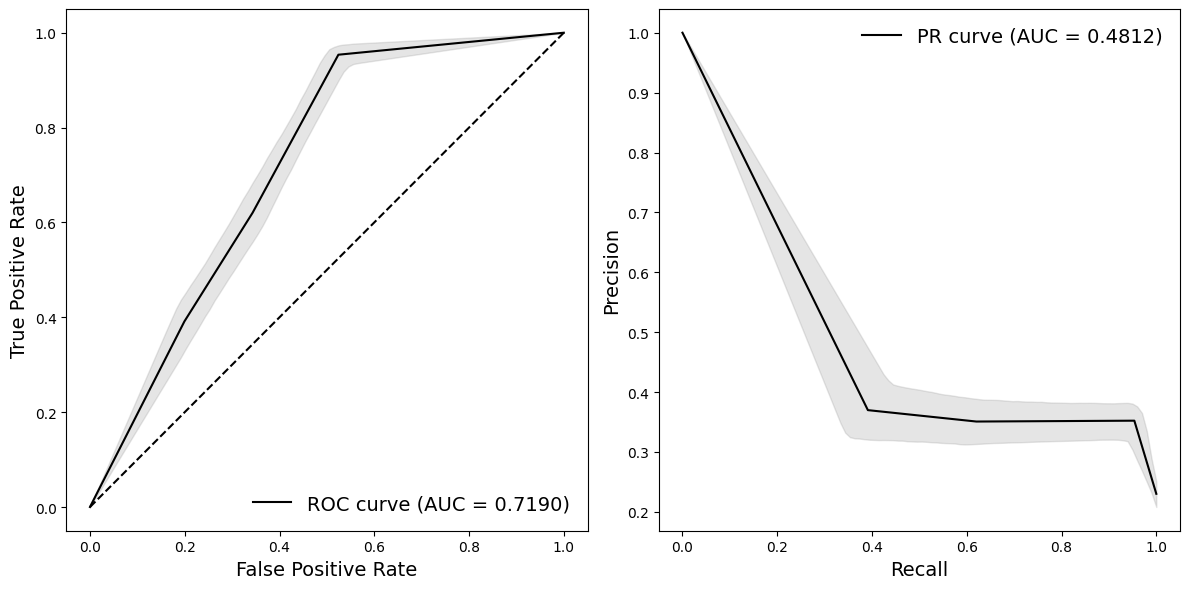

In [24]:
#Plot the AUROC and AUPRC figures. 

#Function to compute confidence intervals using bootstrapping
def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
    stats = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        stat = metric_func(y_true_bs, y_pred_proba_bs)
        stats.append(stat)
    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

#Load models and cutoffs
models = []
cutoffs = []
feature_importances_dict = {}

for fold in range(10):
    with open(f'CPT_only_RF_model_train_fold{fold+1}.pickle', 'rb') as f:
        res = pickle.load(f)
    models.append(res['model'])
    cutoffs.append(res['cutoff'])
    
    #Extract feature importances if available
    model = res['model']
    if hasattr(model, 'feature_importances_'):
        feature_importances_dict[fold] = model.feature_importances_

#Predict on holdout set
y_pred_proba = np.zeros(X_holdout.shape[0])
y_pred = np.zeros(X_holdout.shape[0])

for model, cutoff in zip(models, cutoffs):
    yp_proba = model.predict_proba(X_holdout)[:, 1]
    y_pred_proba += yp_proba
    y_pred += (yp_proba > cutoff).astype(int)

#Average probability and majority vote
y_pred_proba /= len(models)
y_pred = (y_pred > (len(models) / 2)).astype(int)

#Calculate metrics
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
accuracy = accuracy_score(y_holdout, y_pred)
cf_holdout = confusion_matrix(y_holdout, y_pred)

#Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

#Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Function to compute ROC curve for bootstrapping
def bootstrap_roc_curves(y_true, y_pred_proba, num_bootstrap=1000):
    roc_curves = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        fpr, tpr, _ = roc_curve(y_true_bs, y_pred_proba_bs)
        roc_curves.append((fpr, tpr))
    return roc_curves
roc_curves_bootstrap = bootstrap_roc_curves(y_holdout, y_pred_proba, num_bootstrap=1000)

# Function to compute Precision-Recall curves for bootstrapping
def bootstrap_pr_curves(y_true, y_pred_proba, num_bootstrap=1000):
    pr_curves = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        precision, recall, _ = precision_recall_curve(y_true_bs, y_pred_proba_bs)
        pr_curves.append((precision, recall))
    return pr_curves

# Compute bootstrapped Precision-Recall curves
pr_curves_bootstrap = bootstrap_pr_curves(y_holdout, y_pred_proba, num_bootstrap=1000)

#Compute confidence intervals
accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

#Print metrics
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f}")
print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

#Plot ROC Curve with Confidence Intervals
plt.figure(figsize=(12, 6))

#Plot ROC Curve with Confidence Intervals
plt.figure(figsize=(12, 6))

#ROC Curve
plt.subplot(1, 2, 1)
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)

#Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

plt.plot(main_fpr, main_tpr, color='black', label=f'ROC curve (AUC = {main_auc:.4f})')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(frameon=False, fontsize=14)  

#Plot Precision-Recall Curve with Confidence Intervals
plt.subplot(1, 2, 2)
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)

#Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

plt.plot(main_recall, main_precision, color='black', label=f'PR curve (AUC = {main_auc_pr:.4f})')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(frameon=False, fontsize=14)  
plt.tight_layout()
plt.show()

false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]


In [25]:
#Plot the AUROC and AUPRC curves.
def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    specificities = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  
        y_true_resampled = y_true[indices]
        y_pred_proba_resampled = y_pred_proba[indices]
        y_pred_resampled = y_pred[indices]

        #Calculate metrics
        aucs.append(roc_auc_score(y_true_resampled, y_pred_proba_resampled))
        f1s.append(f1_score(y_true_resampled, y_pred_resampled))
        precisions.append(precision_score(y_true_resampled, y_pred_resampled))
        recalls.append(recall_score(y_true_resampled, y_pred_resampled))
        accuracies.append(accuracy_score(y_true_resampled, y_pred_resampled))
        
        #Compute specificity
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
        
        #Compute AUC-PR
        precision, recall, _ = precision_recall_curve(y_true_resampled, y_pred_proba_resampled)
        auc_prs.append(auc(recall, precision))
        
        #Compute ROC and PR curves
        fpr, tpr, _ = roc_curve(y_true_resampled, y_pred_proba_resampled)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    
    #Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    specificity_ci = np.percentile(specificities, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves, pr_curves

#Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_holdout, y_pred_proba, y_pred)

#Calculate metrics on holdout set
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
accuracy = accuracy_score(y_holdout, y_pred)
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel()
specificity_holdout = tn / (tn + fp) if (tn + fp) > 0 else 0
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)

#Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC_Roc: {auc_roc:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Specificity: {specificity_holdout:.4f} (95% CI: {specificity_ci[0]:.4f} - {specificity_ci[1]:.4f})")
print(f"AUC_PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

#Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

#Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

#Plot ROC curve with confidence intervals
plt.figure(figsize=(6, 6))
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)
plt.plot(main_fpr, main_tpr, color='black')  
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.text(0.99, 0.01, f"AUROC: {auc_roc:.3f} (95% CI: {auc_ci[0]:.3f} - {auc_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('CPT_AUC_holdout.png')
plt.show()

#Plot PR curve with confidence intervals
plt.figure(figsize=(6, 6))
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)
plt.plot(main_recall, main_precision, color='black') 
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.text(0.99, 0.01, f"AUPRC: {auc_pr:.3f} (95% CI: {auc_pr_ci[0]:.3f} - {auc_pr_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('CPT_PR_holdout.png')
plt.show()

#Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'specificity', 'auc_pr'],
    'value': [auc_roc, f1_holdout, precision_holdout, recall_holdout, accuracy, specificity_holdout, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], specificity_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], specificity_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('CPT_RC_CI_holdout_metrics.csv', index = False)


Confusion Matrix:
[[758 396]
 [131 214]]
True Negatives (TN): 758
False Positives (FP): 396
False Negatives (FN): 131
True Positives (TP): 214
Specificity: 0.6568
False Positives: 396
False Negatives: 131


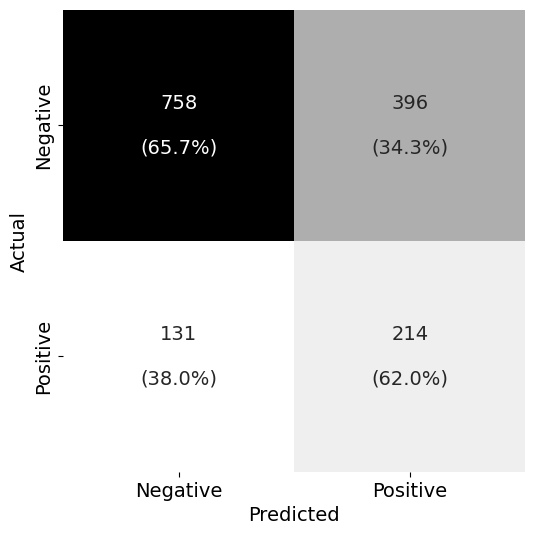

In [23]:
#Compute confusion matrix
cf_holdout = confusion_matrix(y_holdout, y_pred)

#Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

#Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#Print confusion matrix and metrics
print("Confusion Matrix:")
print(cf_holdout)
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

cf_holdout_perc = cf_holdout / cf_holdout.sum(axis=1, keepdims=True) * 100
cf_hold_display = np.empty_like(cf_holdout, dtype=object)
for i in range(cf_holdout.shape[0]):
    for j in range(cf_holdout.shape[1]):
        cf_hold_display[i, j] = f'{cf_holdout[i, j]}\n\n({cf_holdout_perc[i, j]:.1f}%)'

#Plot confusion matrix
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cf_holdout, annot=cf_hold_display, fmt='s', cmap='Greys', 
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'],
                 cbar=False, square=True)  

#Set font size for all text elements
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

#Ensure all annotations have font size 14
for text in ax.texts:
    text.set_fontsize(14)
plt.show()

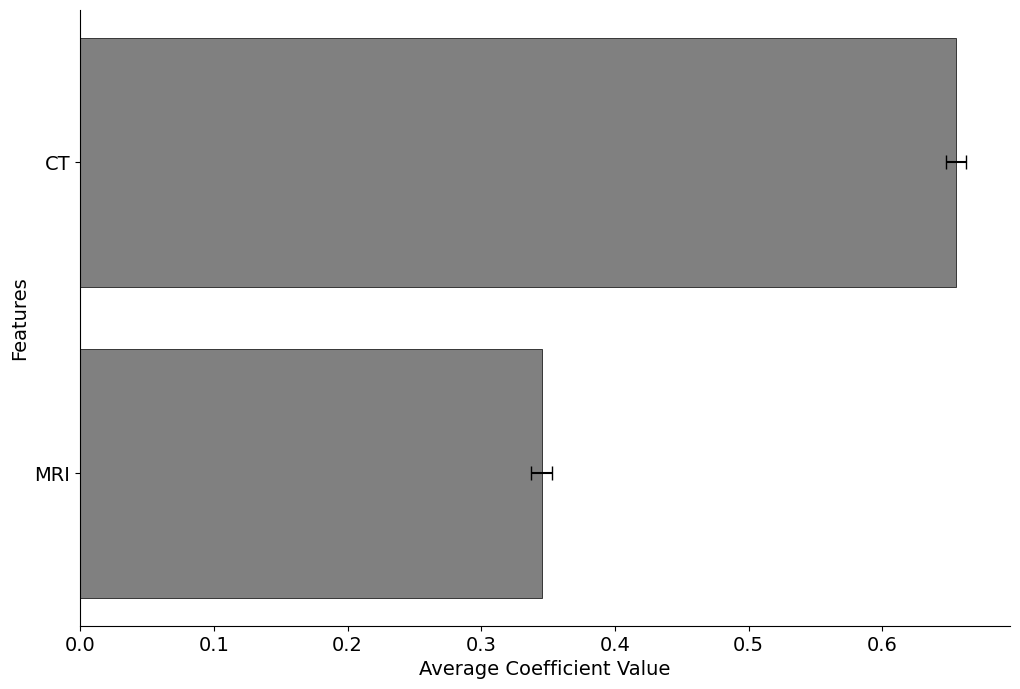

In [17]:
#Compute feature importances
all_feature_importances = np.array([importance for importance in feature_importances_dict.values()])
average_feature_importances = np.mean(all_feature_importances, axis=0)
std_feature_importances = np.std(all_feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': average_feature_importances,
    'Importance_se': std_feature_importances / np.sqrt(len(models))
})

#Sort and select top 10 features
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False, ignore_index=True)
top_features = feature_importance_df.head(10)
bottom_features = feature_importance_df.tail(10)

#Plot feature importances
plt.figure(figsize=(12, 8))
bars = plt.barh(top_features['Feature'], top_features['Importance'], color='grey', 
                xerr=2*top_features['Importance_se'], ecolor='black', capsize=5)

#Set font size for all text elements
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Invert y-axis to show top features at the top
plt.gca().invert_yaxis()

#Ensure all bar labels have font size 14
for bar in bars:
    bar.set_edgecolor('black')  
    bar.set_linewidth(0.5)      
plt.show()

# Save feature importances to CSV
feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/CPT_feature_importances_test.csv', index=False)
